In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy
import itertools
import random

## Data prep

In [2]:
data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'

data_2020 = pd.read_csv(data_dir + 'img_scout_dfs/2020/smr_vis_skysat_scout_2020.csv')
data_2020 = data_2020.rename(columns={"green_red": "grvi"})


In [3]:
# Create binary numeric label
# 0 = low GDM
# 1 = high GDM

data_2020['GDM_sev']=0
data_2020.loc[data_2020['DM_severity'] > 10, 'GDM_sev'] =1
    
data_2020['GDM_inc']=0
data_2020.loc[data_2020['DM_inc'] > 25, 'GDM_inc'] = 1

In [4]:
data_2020.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'grvi', 'green_blue', 'row', 'panel', 'Date',
       'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'GDM_sev', 'GDM_inc'],
      dtype='object')

In [5]:
resp_var = 'GDM_inc'
vis = ['ndvi', 'evi','msavi', 'arvi', 'grvi']

## Find best set of VIs

In [6]:
def get_combinations(lst): # creating a user-defined method
    combination = [] # empty list 
    for r in range(1, len(lst) + 1):
      # to generate combination
      combination += itertools.combinations(lst, r)
    return combination

In [7]:
all_combinations = get_combinations(vis) # method call
print(all_combinations)

[('ndvi',), ('evi',), ('msavi',), ('arvi',), ('grvi',), ('ndvi', 'evi'), ('ndvi', 'msavi'), ('ndvi', 'arvi'), ('ndvi', 'grvi'), ('evi', 'msavi'), ('evi', 'arvi'), ('evi', 'grvi'), ('msavi', 'arvi'), ('msavi', 'grvi'), ('arvi', 'grvi'), ('ndvi', 'evi', 'msavi'), ('ndvi', 'evi', 'arvi'), ('ndvi', 'evi', 'grvi'), ('ndvi', 'msavi', 'arvi'), ('ndvi', 'msavi', 'grvi'), ('ndvi', 'arvi', 'grvi'), ('evi', 'msavi', 'arvi'), ('evi', 'msavi', 'grvi'), ('evi', 'arvi', 'grvi'), ('msavi', 'arvi', 'grvi'), ('ndvi', 'evi', 'msavi', 'arvi'), ('ndvi', 'evi', 'msavi', 'grvi'), ('ndvi', 'evi', 'arvi', 'grvi'), ('ndvi', 'msavi', 'arvi', 'grvi'), ('evi', 'msavi', 'arvi', 'grvi'), ('ndvi', 'evi', 'msavi', 'arvi', 'grvi')]


In [8]:
# Append all possible combinations of vis to the spectral bands
# Result = list of potential explanatory variables

exp_vars = []
for combo in all_combinations:
    combo = list(combo)
    sb = ['blue', 'green', 'red', 'nir']
    sb_plus_vi = sb + combo
    exp_vars.append(sb_plus_vi)
exp_vars

[['blue', 'green', 'red', 'nir', 'ndvi'],
 ['blue', 'green', 'red', 'nir', 'evi'],
 ['blue', 'green', 'red', 'nir', 'msavi'],
 ['blue', 'green', 'red', 'nir', 'arvi'],
 ['blue', 'green', 'red', 'nir', 'grvi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'evi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'msavi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'arvi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'grvi'],
 ['blue', 'green', 'red', 'nir', 'evi', 'msavi'],
 ['blue', 'green', 'red', 'nir', 'evi', 'arvi'],
 ['blue', 'green', 'red', 'nir', 'evi', 'grvi'],
 ['blue', 'green', 'red', 'nir', 'msavi', 'arvi'],
 ['blue', 'green', 'red', 'nir', 'msavi', 'grvi'],
 ['blue', 'green', 'red', 'nir', 'arvi', 'grvi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'evi', 'msavi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'evi', 'arvi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'evi', 'grvi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'msavi', 'arvi'],
 ['blue', 'green', 'red', 'nir', 'ndvi', 'msavi', 'grvi'],


In [9]:
# Prep the dataset: balance the data and scale
## no need to split into train/test
def data_prep(data, expl_vars, resp_vars, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X_rus)
    
    return X_scaled, y_rus #features (scaled) and labels (unscaled)

In [10]:
# Get a dictionary of models for each set of explanatory variables
def get_models(explanatory_vars):
    models = dict()
    for i in exp_vars:
        model = RandomForestClassifier()
        models[str(i)] = model
    return models

In [11]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y,scoring):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # will get 30 (10x3) different results
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [12]:
# Test with the first set of exp. vars(just SB + NDVI)
X,y = data_prep(data_2020, exp_vars[0], resp_var, 2020, 123)
rfm = RandomForestClassifier()

evaluate_model(rfm,X,y,'f1')

array([0.95652174, 0.92307692, 0.88      , 0.81818182, 0.84615385,
       0.85714286, 0.91666667, 0.7826087 , 0.96      , 0.72727273,
       0.91666667, 0.76923077, 0.83333333, 0.88888889, 0.83333333,
       0.96      , 0.95652174, 0.88      , 0.86956522, 0.88      ,
       0.86956522, 0.92307692, 0.78571429, 0.88      , 0.95652174,
       0.96      , 0.8       , 0.95652174, 0.88      , 0.83333333])

In [13]:
# get dataframe of average F1 scores for models with different combinations of explanatory variables
models = get_models(exp_vars)

F1 = []
features = []
for name, model in models.items():
    scores = evaluate_model(model, X, y,'f1')
    F1.append(np.mean(scores))
    features.append(name)

results = pd.DataFrame(columns=['F1', 'features'])
results['F1']=F1
results['features']=features
results

,F1,features
0,0.872783,"['blue', 'green', 'red', 'nir', 'ndvi']"
1,0.883738,"['blue', 'green', 'red', 'nir', 'evi']"
2,0.879444,"['blue', 'green', 'red', 'nir', 'msavi']"
3,0.883365,"['blue', 'green', 'red', 'nir', 'arvi']"
4,0.878817,"['blue', 'green', 'red', 'nir', 'grvi']"
5,0.876114,"['blue', 'green', 'red', 'nir', 'ndvi', 'evi']"
6,0.878704,"['blue', 'green', 'red', 'nir', 'ndvi', 'msavi']"
7,0.872326,"['blue', 'green', 'red', 'nir', 'ndvi', 'arvi']"
8,0.878882,"['blue', 'green', 'red', 'nir', 'ndvi', 'grvi']"
9,0.877078,"['blue', 'green', 'red', 'nir', 'evi', 'msavi']"


In [14]:
# best vi combo (maximizes F1)
results.iloc[results['F1'].idxmax()]['features']

"['blue', 'green', 'red', 'nir', 'evi']"

## Split, balance, normalize

In [15]:
def split_bal_norm(data, expl_vars, resp_vars, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                        test_size=0.3, 
                                                        random_state=seed,
                                                        stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [16]:
X_train, y_train, X_test, y_test = split_bal_norm(data_2020,
                                                  ['blue', 'green', 'red', 'nir', 'ndvi'],
                                                 resp_var,
                                                 2020,
                                                 14)

## Hyperparameter tuning (training set only)

In [17]:
# Create dictionary of parameters to test with randomizedCV

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
num = 5)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [18]:
rfc = RandomForestClassifier()

In [19]:
rs = RandomizedSearchCV(rfc,
param_dist,
n_iter = 100,
scoring = 'f1',
cv = 3,
verbose = 1,
n_jobs=-1,
random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 7,
 'min_samples_leaf': 13,
 'max_features': 'log2',
 'max_depth': 15,
 'bootstrap': True}

In [20]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'std_test_score'],
axis=1)

rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,300,12,13,sqrt,9,True,0.919883,1
1,800,12,13,sqrt,15,True,0.919883,1
2,900,2,13,log2,8,True,0.919883,1
3,700,7,13,log2,15,True,0.919883,1
4,400,34,13,log2,3,True,0.919883,1
5,700,18,1,log2,7,True,0.907143,6
6,300,39,1,log2,6,True,0.906699,7
7,1000,50,1,sqrt,8,True,0.906699,7
8,600,39,13,sqrt,10,False,0.906699,7
9,600,28,25,sqrt,1,True,0.906699,7


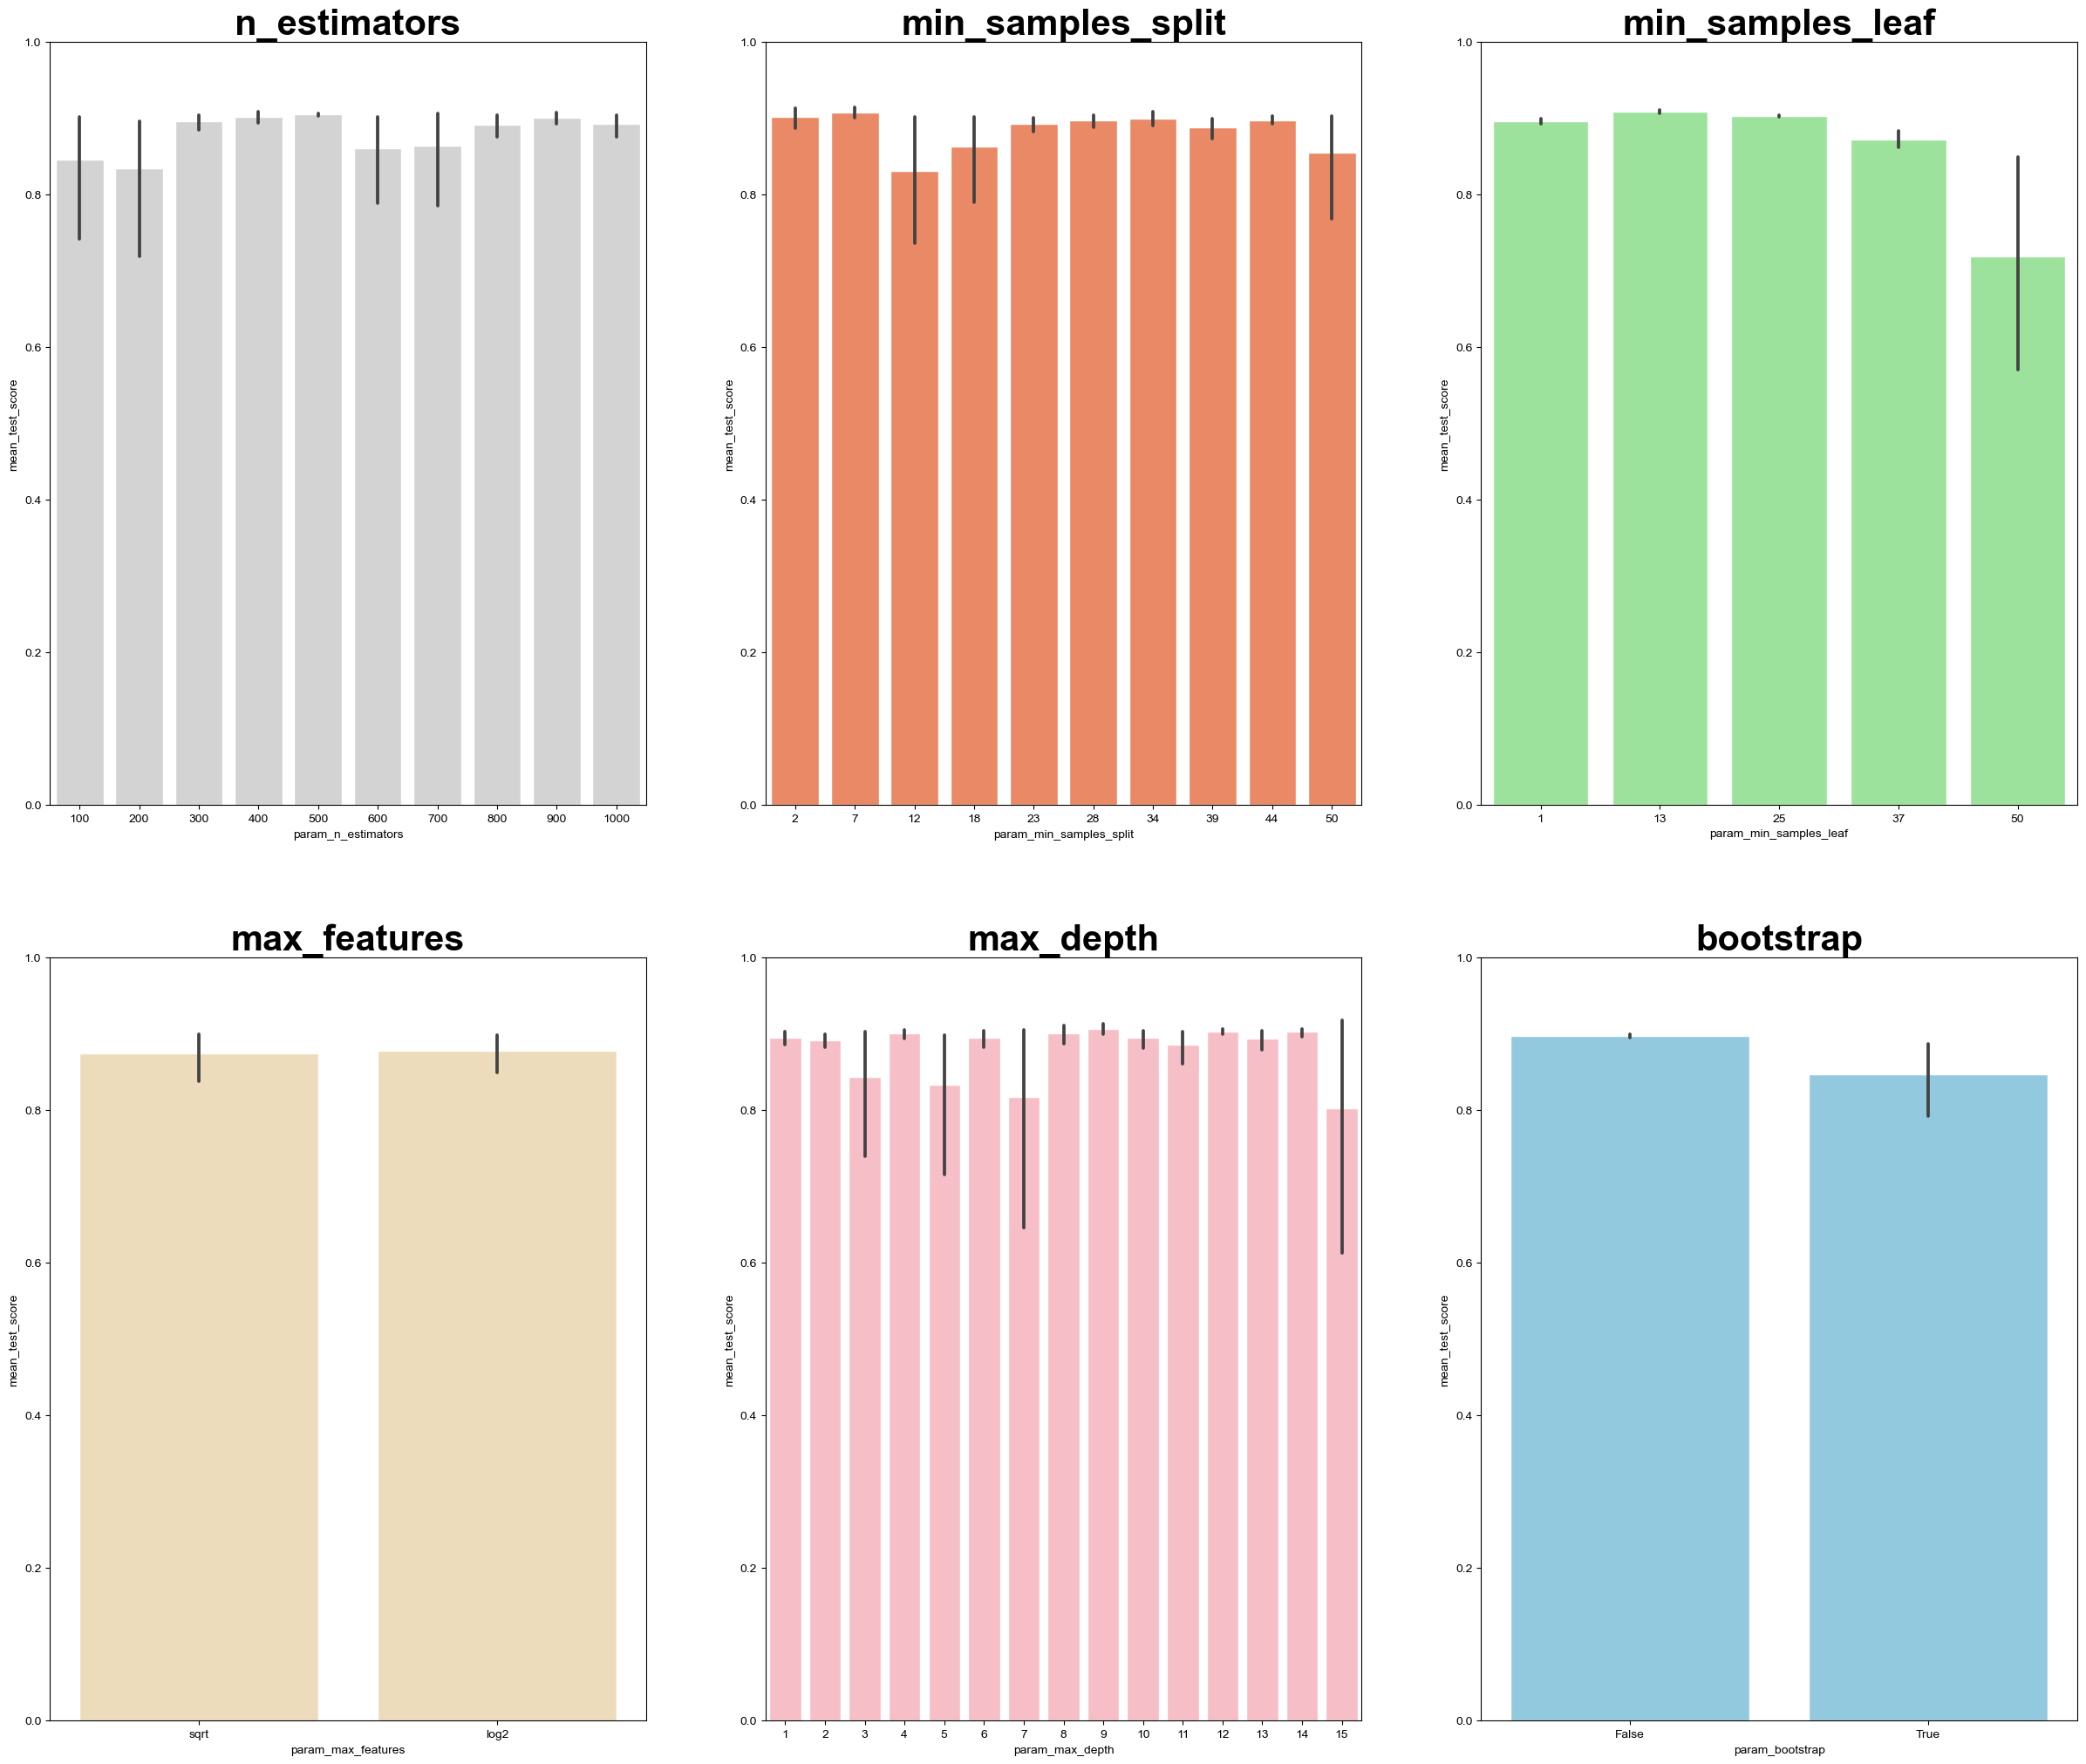

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df,
ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.0,1])
axs[0,0].set_title(label = 'n_estimators',
size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score',
data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.0,1])
axs[0,1].set_title(label =
'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score',
data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.0,1])
axs[0,2].set_title(label =
'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df,
ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.0,1])
axs[1,0].set_title(label = 'max_features',
size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df,
ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.0,1])
axs[1,1].set_title(label = 'max_depth',
size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df,
ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.0,1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,300,400,500]
max_features = ['sqrt','log2']
max_depth = [3,8,13,14,15]
min_samples_split = [2,7,12,18,34]
min_samples_leaf = [1,2,7,13]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 34,
 'n_estimators': 300}

In [26]:
y_pred_gs = rfc_2.predict(X_test)

In [27]:
## Plot confusion matrix and get all model metrics

[[26  9]
 [ 2 34]]
              precision    recall  f1-score   support

           0       0.93      0.74      0.83        35
           1       0.79      0.94      0.86        36

    accuracy                           0.85        71
   macro avg       0.86      0.84      0.84        71
weighted avg       0.86      0.85      0.84        71



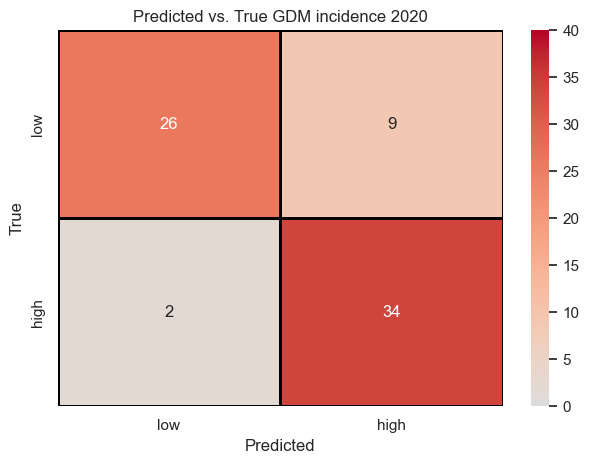

In [39]:
from sklearn.metrics import confusion_matrix                            



cf_matrix = confusion_matrix(y_test, y_pred_gs)
print(cf_matrix)

sns.set(font_scale=1)
sns.heatmap(cf_matrix, annot=True,
           vmin=0, vmax=40, center= 0,
           cmap= 'coolwarm', linewidths=2, linecolor='black',
           xticklabels=['low','high'],
           yticklabels=['low','high']).set(title='Predicted vs. True GDM incidence 2020');

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

report = classification_report(y_test, y_pred_gs)

print(report)
# conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
#         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# display(conf_matrix_tuned)
# display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

In [29]:
# Make sure axes are properly labeled
unique, counts = np.unique(y_pred, return_counts=True)

dict(zip(unique, counts))

{0: 28, 1: 43}

## Permutation importance plots

In [30]:
# Get permutation feature imp. scores
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

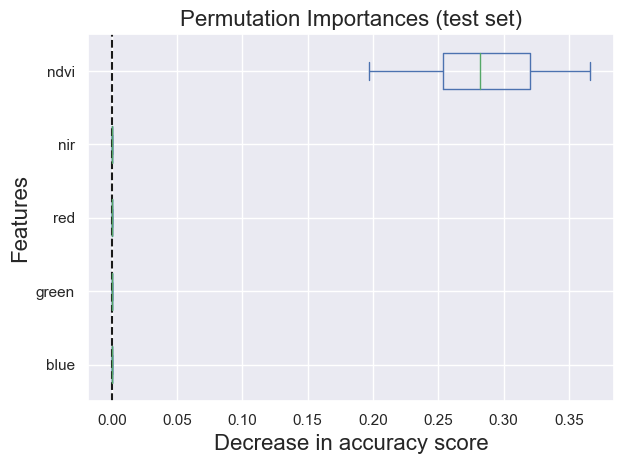

In [40]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data_2020[['blue', 'green', 'red', 'nir', 'ndvi']].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

ax.figure.tight_layout()